# Trademark Generator
A model to generate trademark names.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xnartharax/MachineLearning-experiments/blob/master/TrademarkGenerator.ipynb)  
 The data comes from th [DPMA](https://register.dpma.de/DPMAregister/uebersicht). To get this install [git](https://git-scm.com/book/de/v1/Los-geht%E2%80%99s-Git-installieren) navigate to your desired directory with the `cd` command and use `git clone https://github.com/Xnartharax/MachineLearning-experiments`. To use this interactively install [anaconda](https://www.anaconda.com/distribution/#download-section) (The Python 3.7 version) and run `conda install pytorch` in the anaconda prompt. Then open a jupyter lab through the anaconda navigator and open the notebook from there.

In [0]:
%matplotlib inline
import os
from IPython.display import display, clear_output
import pandas as pd
import string
import torch
import torch.nn as nn
import numpy as np
from math import floor, ceil
import sys
import string
import matplotlib
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence, pad_sequence, pack_padded_sequence
plt.rcParams['figure.figsize'] = [9.5, 6]

## Utility functions
Those are bunch of functions used to encode and decode the inputs and outputs of the network.
### Char to onehot
This converts a character into its onehot representation. Onehot vectors are used for multiclass input.All elements are zero except the one with the index of the correct label. E.g. we have the character `G`  the 7th letter in the alphabet so the onehot representation looks like `[0, 0, 0, 0, 0, 0, 1, 0, 0, ...]`
### Sequence Encodeing
This applies the aforementioned method to a string of characters. Since this function is only used for the input we only have to insert the Start-of-sequence-character (`<SOS>`). The last letter wich would be end-of-sequence (`<EOS>`) isn't passed as input.
### Decoding target and output sequences
This converts the numeric output of the network into human-readable text. We need two different functions here because target and output are differently formatted.  
**TODO:** make a probabilistic sequence decoding

In [0]:
def char_to_onehot(char):
    return [1 if char==alphabet[i] else 0 for i, _ in enumerate(alphabet)]

def encode_sequence(sequence):
    seq = list(sequence)
    seq.insert(0, "<SOS>")
    out = [char_to_onehot(char) for char in seq]
    return out

def decode_sequence(sequence):
    chars = [alphabet[torch.argmax(char)] for char in sequence]
    decoded = ""
    for char in chars:
        decoded += char
    return decoded

def decode_target_seq(target_seq):
    decoded = ""
    for t in target_seq:
        decoded += alphabet[t.item()]
    return decoded

## Data inport
See the [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/)

In [3]:
df = pd.read_csv("https://github.com/Xnartharax/MachineLearning-experiments/raw/master/treffer.csv", sep=';', error_bad_lines=False)

df.drop(columns=["Datenbestand", "Aktenzeichen/Registernummer", "Aktenzustand"], inplace=True)
everything = []
for _, row in df.iterrows():
    everything += list(row["Markendarstellung"].upper())
alphabet = ["<pad>"] + list(set(everything)) + ["<SOS>", "<EOS>"]
print(len(alphabet))

100


## The data preprocessing
Here the data is preprocessed for training. If you wonder what those loops in the brackets are: they are called [list comprehensions](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python) (they are pretty useful and compact).

In [0]:
features =[encode_sequence(seq["Markendarstellung"].upper()) for i, seq in df.iterrows()]
targets = [[alphabet.index(char) for char in list(seq["Markendarstellung"].upper())]+[len(alphabet)-1]\
                  for i, seq in df.iterrows()]

## Batches
A batch is a small `sub-dataset` after wich an update is computed. This is useful because we don't have to pass the entire dataset for one update so we can accelerate the learning process. 

This method takes the feature and target dataset, a batch number i and the total number of batches as input. It then calculates a batch length and picks data areas. The batches are then sorted by sequence length because the packed sequences must be in that order.

### Packed and padded sequences

There are different methods to handle sequences in batches: Padding and Packing.

#### Packed sequences
***
A packed sequences are fused together in a list. Additionally the lengths of the batch at each step are stored.

**Example:**
Consider the sequences: abc, abcdef, qrstu

In packed form they look like: `aaqbbrccsdteuf`
with the stored seperations: `3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1`

#### Padded sequences
***
Packed sequences have paddings inserted at the end to bring them all up to equal length.

**Example:**
Same sequences as before: abc, abcdef, qrstu

padded they look like `abc<pad><pad><pad>, abcdef, qrstu<pad>`

In [0]:
def get_batch(features, targets, i, n_batches):
    batch_len = int(floor(len(features)/n_batches))
    
    batch_features = sorted(features[i*batch_len:(i+1)*batch_len],
                            key=lambda x: len(x), reverse=True)
    batch_targets = sorted(targets[i*batch_len:(i+1)*batch_len],
                           key=lambda x: len(x), reverse=True)
    padded_features = pad_sequence([torch.tensor(seq, dtype=torch.float32).view(-1, len(alphabet))\
                                        for seq in batch_features])
    padded_targets = pad_sequence([torch.tensor(target) for target in batch_targets])
    if torch.cuda.is_available():
      return (padded_features.cuda(),\
            padded_targets.cuda(), batch_len)
    else:
      return (padded_features,\
            padded_targets, batch_len)

## The LSTM Wrapper
This class wraps things like [residual shortcuts](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec), dropout and batch normalization around an LSTM. The weight initialization is also important. Otherwise the network fails tolearn. The weights are sampled from a normal distribution with a mean equal to: $\frac{1}{\sqrt{N_{input}}}$

In [0]:
class LSTMBlock(nn.Module):
    def __init__(self, in_size, out_size, residual=False, 
                 dropout_p=0, layer_norm=False):
        super(LSTMBlock, self).__init__()
        self.core = nn.LSTM(in_size, out_size)
        # weight init
        y = 1/np.sqrt(in_size)
        self.core.weight_ih_l0.data.normal_(y)
        self.core.weight_hh_l0.data.normal_(y)
        # residual shortcuts
        self.residual = residual
        if self.residual:
            self.resShortcut = nn.Linear(in_size, out_size)
        # batch norm
        self.norm = nn.LayerNorm(out_size) if layer_norm else nn.Identity()
        # dropout
        self.dropout = nn.Dropout(p=0)
        
    def forward(self, inputs, hidden):
        out, hidden = self.core(inputs, hidden)
        if self.residual:
            # transforming the input dimensions to match the output dimensions
            inputs_transformed = self.resShortcut(inputs)
            out = out + inputs_transformed
        out= self.norm(out)
        return out, hidden

## The Char Predictor Class
Pretty obvious: given a sequence of characters the Char preditor will compute likelihoods of the next chars. It is the  core part for generating a sequence 
### Constructor
****
It takes a tuple of integers as argument. This is a convenient way to quickly redefine the network architecture. All layers except the last will be LSTM layers. The last layer is a straightforward linear layer on wich a softmax follows. The Softmax normalizes all outputs to sum up to 1 and exponentially magnifies the most promisiing outputs. The outputs can be interpreted as likelihoods because they sum up to one.
$$softmax_i(x) = \frac{e^{x_i}} {\sum \limits_{j} e^{x_j}}$$
### Forward-Passing
****
We use  to prevent a vanishing gradient. Since linear layers don't work with packed sequences, the data has to be converted into a padded sequence before propagating to the final layer.
### Training
****
Probably the most convoluted and messy method due to constant tinkering. It uses mini-batch learning wich means you have two loops: one for the epochs, one for the batches. In each epoch we determine how many batches to use wich determines how big the batches are. Increasing the size of the batches during training is an alternative to decreasing the learning rate because larger batches mean more accurate descent. First thing to do in the batch loop is to set the gradients to zero because torch accumulates gradients otherwise. After that we get a data batch on wich we compute our preditions and evaluate a given loss function. `loss.backward()` computes the gradients used by `optim.step()`. After that an evaluation loss is computed with a seperate evaluation dataset. If the evaluation loss is smaller than 3 and the currently best loss a checkpoint is saved.

**TODO:** 
1. Accuracy evaluation
2. Seperate the Training process into a Trainer class
3. Directly calculate batch length and take n_batches from there

### Checkpoints
****
see [the Documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [0]:
class CharPredictor(nn.Module):
    def __init__(self, structure, dropout_p=0.1, residual=False,
                 layer_norm=False, hidden_init=torch.zeros):
        super(CharPredictor, self).__init__()
        # important meta-information
        self.structure = structure
        self.layers = len(structure)
        self.hidden_init = hidden_init
        # the actual network
        self.lstms = nn.ModuleList([LSTMBlock(i, o, dropout_p=dropout_p,                                              
                                    residual=False, layer_norm=layer_norm)
                                    for i, o in zip(structure[:-2], structure[1:-1])])
        self.final = nn.Linear(structure[-2], structure[-1])
        self.final.weight.data.normal_(1/np.sqrt(structure[-1]))
        self.activation = nn.Softmax(dim=2)
        
    def forward(self, seq, keep_hidden_state=False, batch_size=1, plots={}):
        # diagnostic plots please ignore
        if "activations" in plots:
            means = []
        if "stds" in plots:
            stds = []
        if "variances" in plots:
            variances = []
            
        # if you want to pass single characters enable keeping the hidden state of the LSTMs
        # otherwise the network assumes that each forward pass is a new sequence
        if not keep_hidden_state:
            self.init_hidden(batch_size)
            
        # important part   
        inputs = seq
        for i, lstm in enumerate(self.lstms):
            # using output of the previous layer as input for all layers but the first
            out, self.hidden[i] = lstm(inputs, self.hidden[i]) 
            inputs = out
            #more monitoring plots
            if "activations" in plots:
                means.append(out.data.abs().mean().item())  
            if "stds" in plots:
                stds.append(out.data.std().item())
            if "variances" in plots:
                variances.append(out.data.var().item())
                
        # fancy data reformatting because Dense layers can't handle packed sequences

        out = self.activation(self.final(out))
        
        
        # even more dagnostic plot stuff
        if "activations" in plots:
            means.append(out.mean().item())
            plots["activations"].set_data(range(len(self.structure)-1), means)
        if "stds" in plots:
            stds.append(out.std().item())
            plots["stds"].set_data(range(len(self.structure)-1), stds)
        if "variances" in plots:
            variances.append(out.var().item())
            plots["variances"].set_data(range(len(self.structure)-1), variances)
        
        return out
    
    def fit(self, seqs, targets, eval_seqs, eval_targets, epochs, n_batches, 
            optim, criterion,
              plots={}, start_epoch=0, losses=[], eval_losses=[]):
        best_loss = 100
        # preparing the evaluation data
        eval_X, eval_y, eval_batch_len = get_batch(eval_seqs, eval_targets, 0, 1)
        
        for epoch in range(start_epoch, epochs):
            # decreasing the number of batches with each epoch
            N_batches = ceil(n_batches * (0.99**epoch))
            for batch in range(N_batches):
                model.zero_grad()
                
                # getting the batch data
                X, y, batch_len = get_batch(seqs, targets, batch, N_batches)
                
                # computing the Predictions
                y_hat = self(X, plots=plots, batch_size=batch_len)
                
                # computing the loss
                loss = criterion(y_hat, y)
                
                # computing the gradients
                loss.backward()
                
                #  computing evaluation predictions and loss
                eval_y_hat = self(eval_X, batch_size=eval_batch_len)
                eval_loss = criterion(eval_y_hat, eval_y)
                
                # plotting stuff
                if "grads" in plots:
                    grads = [lstm.core.weight_ih_l0.grad.abs().mean() + \
                             lstm.core.weight_hh_l0.grad.abs().mean()
                             for lstm in self.lstms] \
                    + [self.final.weight.grad.mean()]
                    
                #applying the updates
                optim.step() 
                
                # monitoring
                clear_output()
                print(f'{epoch}:{batch}/{N_batches}|{loss.cpu().detach().numpy()}|{eval_loss.cpu().detach().numpy()}' )
                losses.append(loss.cpu().detach().numpy())
                eval_losses.append(eval_loss.cpu().detach().numpy())
                if plots != {}:
                    if "loss" in plots:
                        plots["loss"].set_data(range(len(losses)), losses)
                    if "grads" in plots:
                        plots["grads"].set_data(range(len(self.structure)-1),
                                                grads)
                    if "eval_loss" in plots:
                        plots["eval_loss"].set_data(range(len(eval_losses)),
                                                    eval_losses)
                    display(plots["fig"])
                
                # saving the checkpoints
                # if(eval_loss<3 and eval_loss<best_loss):
                #     self.save_checkpoint(losses, eval_losses, epoch, optim)
                #     best_loss = eval_loss.detach()
                #     print("saved checkpoint")
                    
    def append_layer(self, n_neurons, dropout_p=0, residual=False,
                     batch_norm=False):
        self.lstms.append(LSTMBlock(self.structure[-2], n_neurons,
                                    dropout_p=dropout_p, residual=False,
                                    batch_norm=batch_norm))
        temp = list(self.structure)
        temp.insert(-1, n_neurons)
        self.structure= tuple(temp)
        self.layers+=1
        self.final = nn.Linear(n_neurons, self.structure[-1])
                    
    def init_hidden(self, batches):
        if torch.cuda.is_available:
            self.hidden = [(self.hidden_init(1, batches, layer_size).cuda(),
                       self.hidden_init(1, batches, layer_size).cuda())
                           for layer_size in self.structure[1:]] 
        else:
            self.hidden = [(self.hidden_init(1, batches, layer_size),
                       self.hidden_init(1, batches, layer_size))
                           for layer_size in self.structure[1:]] 
        
    def save_checkpoint(self, losses, eval_losses, epoch, optim):
        if os.path.exists("./safepoints/safepoint.pt"):
            os.remove("./safepoints/safepoint.pt")
        torch.save({
            "model_state_dict":self.state_dict(),
            "optim_state_dict":optim.state_dict(),
            "losses":losses,
            "eval_losses":eval_losses,
            "epoch":epoch,
        },f"./safepoints/safepoint.pt")
    def resume_from_checkpoint(self, seqs, targets, eval_seqs, eval_targets,epochs, n_batches, optim, criterion,
                               plots={}, checkpoint='./safepoints/safepoint.pt'):
        state_dict = torch.load(checkpoint)
        self.load_state_dict(state_dict["model_state_dict"])
        optim.load_state_dict
        self.fit(seqs, targets, eval_seqs, eval_targets, epochs, n_batches, optim, criterion, plots=plots,
                   start_epoch=state_dict["epoch"], losses=state_dict["losses"], eval_losses=state_dict["eval_losses"])
        

## Pre-Training definitions
Structure definition an model initialization should be clear. 

In [0]:
model = CharPredictor((len(alphabet), 150, 150, len(alphabet)))
if torch.cuda.is_available():
  model.cuda()

## Training Parameters
Here we choose Optimizer, Loss function and number of epochs and batches
### Loss Function: The Negative Log likelihood Loss (NLL)
This is the standard for multiclass sequence regression ([more Info](https://pytorch.org/docs/stable/nn.html#nllloss)). ~~It is important to weigh the extra symbols less because they are more frequent.  
The number of occurencies of the padding should roughly be half the average size of sequences, `<SOS>` is never in the target sequence and `<EOS>` appears in every target sequence.~~
### The Adam Optimizer
See [great source for optimizers](http://ruder.io/optimizing-gradient-descent/).
### Batches and Epochs
The batches are set to contain roughly 200 or more data points each and the epochs are far more than actually needed (i think).

In [0]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
occurencies = [everything.count(char)for char in alphabet[1:-2]]
occurencies = [occ if occ>10 else 100000 for occ in occurencies] # a 1 causes the inverse log to be infinite and we dont want the rare letters in there
weights = [torch.tensor([len(seq) for seq in features], dtype=torch.float).mean().item()*len(features)]\
        + occurencies + [0, len(features)] 
lossweight = 1/torch.log(torch.tensor(weights))
if torch.cuda.is_available():
    lossweight = lossweight.cuda()
loss_func = nn.NLLLoss()
epochs = 50
n_batches = 99
def criterion(y_hat, y):
    main_loss = loss_func(torch.log(y_hat).view(-1, len(alphabet)), y.view(-1))
    loss = main_loss# + weight_punishment**0.0002 + 1*0.000001/y_hat.var()
    return loss

## Training and monitoring
This starts the training loop. It displays some metrics of the learning progress. In the top left corner the training loss (blue) and the evaluation loss (red) are shown.  
In the top right you can see the average magnitude of the activation (red) the standard deviations (blue) and the variances (green) per layer. Because of the softmax the activation average will be fixed but standard deviation and variance should be higher since that means the model is deciding for a specific label.  
In the bottom left there is the average magnitude of the gradient per layer. This shows how much each layer is adjusted.  
The bottom right is currently empty. This is where an accuracy plot could go.  
You don't really have to understand how it works but if you really want to here is the [matplotlib documentation](https://matplotlib.org/).  
**BUG:** It doesn't clear the plot when reinitializing the model or restarting the learning process

49:60/61|0.5251199007034302|0.6518093347549438


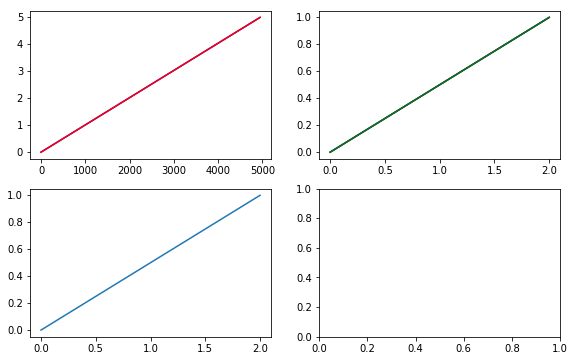

In [10]:
fig, ((lax, aax), (gax, accax)) = plt.subplots(ncols=2, nrows=2)
plots = {
    "fig":fig, 
    "activations":aax.plot([0, len(model.structure)-2], [0, 1], "r")[0],
    "stds":aax.plot([0, len(model.structure)-2], [0, 1], "b")[0],
    "variances":aax.plot([0, len(model.structure)-2], [0, 1], "g")[0],
    "loss":lax.plot([0, epochs*n_batches], [0, 5], "b")[0],
    "eval_loss":lax.plot([0, epochs*n_batches], [0,  5], "r")[0],
    "grads":gax.plot([0, len(model.structure)-2], [0, 1])[0],
#     "accuracy":accax.plot([0, epochs*n_batches], [0, 1])
}  
model.train()
model.fit(features[100:10000], targets[100:10000], features[:100], targets[:100], epochs, n_batches, optim, criterion)
#torch.save(model, "./good_try.pt") 

In [13]:
ins, target, batch_len = get_batch(features, targets, 112, 1000)
model.eval()
print(model.training)

print(decode_sequence(model(ins, batch_size=10)[:, 2, :]))
print(decode_target_seq(target[:, 2]))

False
SROTONECANRO EI<EOS><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
PHOTON MICROGUI<EOS><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


## How to go on
The Character prediction is just the core part of the Generator. We still need to think about thinks like the starting input for generation (the seed), the output sampling method and a general application of this thing. This [Medium article ](https://towardsdatascience.com/the-arti-canon-neural-text-generation-2a8f032c2a68) gives a broader overview. If you want to learn how everything works you can take on the TODOs. Here are some things I'd like to try for the Predictor:
- Train on a small dataset. Then add some more data. Train again. Add more data and so on...
- Adding more layers through time.
- Regularization (Dropout, L1, L2, etc.)
- Look into [Transformers](https://arxiv.org/pdf/1706.03762.pdf)/Attention
- Experiment with other datasets/more context
- more data

## Saving the model
Please have a coherent naming convention. Name structure and methods used for training like dropout and residual shortcuts.

In [0]:
torch.save(model.state_dict(), './200-200-dropout.tsd')